In [1]:
from __future__ import print_function, division

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['figure.figsize'] = np.array((5,4))*1.5
from matplotlib import pyplot as plt
import seaborn as sns; sns.set(context="poster", style="ticks")
import os
import glob



from units import M_solar, m_proton, pc, yr, Myr, km, s, gamma

from injection_helpers import get_SNe

from visualize_helpers import \
    total_radial_momentum_of_snapshot, \
    map_to_all_snapshots, \
    get_snapshot_times, \
    load_snapshots
    
from sql_helpers import add_simulation, \
    open_as_DataFrame, get_db_dirname_tmp


/pfs/home/egentry/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


`grackle_helpers.wrapped_initializer` is setting up grackle assuming code units:
    mass   : 1.0 M_solar
    length : 1.0 pc
    time   : 1.0 Myr

grackle cooling file:  b'/pfs/home/egentry/local/grackle/input/CloudyData_UVB=HM2012.h5'
`grackle_helpers.wrapped_initializer` is setting up grackle assuming code units:
    mass   : 8.41e-58 M_solar
    length : 3.24e-19 pc
    time   : 3.17e-14 Myr

grackle cooling file:  b'/pfs/home/egentry/local/grackle/input/CloudyData_UVB=HM2012.h5'


In [2]:
db_dir_tmp = get_db_dirname_tmp()
if not os.path.exists(db_dir_tmp):
    print("making temporary database directory: ", db_dir_tmp)
    os.mkdir(db_dir_tmp)

## 1D (hi-res)

In [3]:
## Boilerplate path hack to give access to full clustered_SNe package
import sys, os
if __package__ is None:
    if os.pardir not in sys.path[0]:
        file_dir = os.getcwd()
        sys.path.insert(0, os.path.join(file_dir, 
                                        os.pardir, 
                                        os.pardir))
        
from clustered_SNe.analysis.parse import Overview, RunSummary

In [4]:
data_dir_1D = "1D_data/"

run_summary = RunSummary(data_dir_1D, "F5509BF1-3F9E-4008-B795-0482ECED199B")

# 3D (resolution study)

In [5]:
base_box_size = 400

N_particles_per_side = np.array([
        100, 
#         150, 
        200, 
#         250, 
#         300,
        400, 
#         600,
    ])
dxs = base_box_size / N_particles_per_side

simulation_base_name = "cluster_cooling"

run_names = {N : "{}_{}".format(simulation_base_name, N)
             for N in N_particles_per_side}

snapshot_dirs = {N : "../runs/{}/outputs".format(run_names[N])
                for N in run_names}


In [6]:
SNe_dir = list(snapshot_dirs.values())[0].replace("outputs", "inputs")
SNe = get_SNe(SNe_dir)
SN_times_3D = np.array([SN.time for SN in SNe])

In [7]:
def copy_and_get_DataFrames(run_name):
    df = open_as_DataFrame(run_name, copy_first=True)
    
    return df


# Read in HD runs

In [8]:
snapshot_dirs_tmp = [snapshot_dirs[N_particles_per_side_i]
                     for N_particles_per_side_i in N_particles_per_side]

run_names_tmp = [run_names[N_particles_per_side_i]
                 for N_particles_per_side_i in N_particles_per_side]


outputs = list(map(copy_and_get_DataFrames, run_names_tmp))

times_snapshots = {N_particles_per_side_i : outputs[i].time
                   for i, N_particles_per_side_i in enumerate(N_particles_per_side)}

radial_momenta  = {N_particles_per_side_i : outputs[i].momentum
                   for i, N_particles_per_side_i in enumerate(N_particles_per_side)}


# Read in MHD runs

In [13]:
base_box_size = 400

N_particles_per_side_mhd = np.array([
        100, 
#         150, 
        200, 
#         250, 
#         300,
#         600,
    ])
dxs_mhd = base_box_size / N_particles_per_side_mhd

simulation_base_name_mhd = "cluster_cooling_mhd_large"

run_names_mhd = {N : "{}_{}".format(simulation_base_name_mhd, N)
                 for N in N_particles_per_side_mhd}

snapshot_dirs_mhd = {N : "../runs/{}/outputs".format(run_names_mhd[N])
                     for N in N_particles_per_side_mhd}

run_names_mhd[100] = run_names_mhd[100].replace("_large", "")
snapshot_dirs_mhd[100] = snapshot_dirs_mhd[100].replace("_large", "")

In [14]:
snapshot_dirs_tmp = [snapshot_dirs_mhd[N_particles_per_side_i]
                     for N_particles_per_side_i in N_particles_per_side_mhd]

run_names_tmp = [run_names_mhd[N_particles_per_side_i]
                 for N_particles_per_side_i in N_particles_per_side_mhd]

outputs_mhd = list(map(copy_and_get_DataFrames, run_names_tmp))

times_snapshots_mhd = {N_particles_per_side_i : outputs_mhd[i].time
                       for i, N_particles_per_side_i in enumerate(N_particles_per_side_mhd)}

radial_momenta_mhd = {N_particles_per_side_i : outputs_mhd[i].momentum
                       for i, N_particles_per_side_i in enumerate(N_particles_per_side_mhd)}


# Plot

In [15]:
min_N_default = min(N_particles_per_side.min(), N_particles_per_side_mhd.min())
max_N_default = max(N_particles_per_side.max(), N_particles_per_side_mhd.max())

def N_particles_to_color(N_particles, 
                         min_N=min_N_default, max_N=max_N_default,
                         verbose=False, invert=False):

    if verbose:
        print("min_N: ", min_N)
        print("max_N: ", max_N)
    
    # log space the colorscale
    x = (np.log(N_particles)-np.log(min_N)) / (np.log(max_N) - np.log(min_N))
    if verbose:
        print("x:     ", x)
        
    if invert:
        x = 1-x
        
    color = plt.cm.viridis_r( x )
    
    return color
    

In [16]:
def resolution_study_plotter(N_particles_per_side,     times_snapshots,     radial_momenta,
                             N_particles_per_side_mhd, times_snapshots_mhd, radial_momenta_mhd,
                             with_1D=True,
                             with_MHD=True,
                             with_rugplot=True,
                             with_log_yscale=True,
                             with_legend=True,
                             axes_style="ticks",
                             ):
    with sns.axes_style(axes_style):
        if with_1D:
            plt.plot((run_summary.times - run_summary.overview.SNe_times[0]) / (Myr),
                     run_summary.momentum / (100 * M_solar * 11 * km / s),
                     label="1D",
                     linestyle="dotted", color="k",
                     )


        for N_particles_per_side_i in N_particles_per_side[::-1]:

            plt.plot(times_snapshots[N_particles_per_side_i],
                     radial_momenta[N_particles_per_side_i] / (100 * M_solar * 11 * km / s),
                     label="3D: $\Delta x = $ {:.1f} pc".format(400 / N_particles_per_side_i),
                     color=N_particles_to_color(N_particles_per_side_i, min_N=75),
                     )
        if with_MHD:
            for N_particles_per_side_i in N_particles_per_side_mhd[::-1]:

                plt.plot(times_snapshots_mhd[N_particles_per_side_i],
                         radial_momenta_mhd[N_particles_per_side_i] / (100 * M_solar * 11 * km / s),
                         label="3D MHD: $\Delta x = $ {:.1f} pc".format(400 / N_particles_per_side_i),
                         linestyle="dashed", 
                         color=N_particles_to_color(N_particles_per_side_i, min_N=75),
                        )

        if with_rugplot:
            sns.rugplot(SN_times_3D, color="k", linewidth=3)

        plt.xlabel(r"$t$ $[\mathrm{Myr}]$")
        plt.ylabel(r"$p / (100$ $M_\odot$ $N_\mathrm{SNe})$ $[\mathrm{km}$ $\mathrm{s}^{-1}]$")


        plt.xlim(xmin=-1,
                 xmax=40)
        plt.ylim(ymin=300,
                 ymax=3000,
                )

        if with_log_yscale:
            plt.yscale("log")

#         if with_legend:
        plt.legend(loc="best")

## All the runs

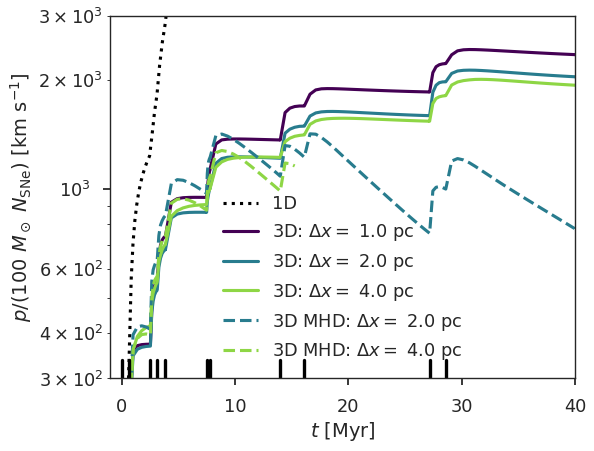

In [17]:
resolution_study_plotter(N_particles_per_side, times_snapshots, radial_momenta,
                         N_particles_per_side_mhd, times_snapshots_mhd, radial_momenta_mhd,)

# Just the even powers of 2

In [18]:
N_particles_tmp = np.array([100,200,400])

## Without MHD

In [19]:
isolated_SN_momentum = radial_momenta[200][6] / (100 * M_solar * km/s)
isolated_SN_momentum

2351.4539337061497

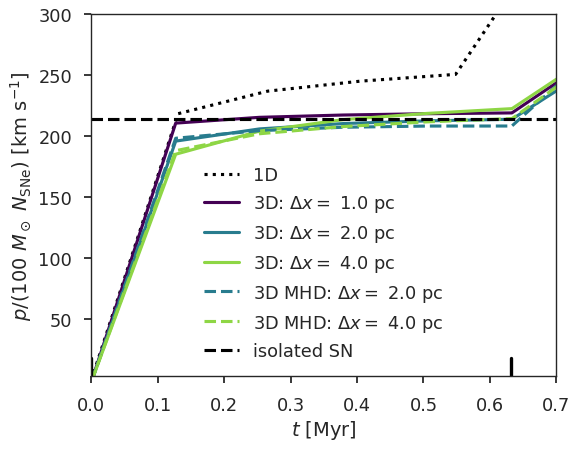

In [20]:
resolution_study_plotter(N_particles_tmp, times_snapshots, radial_momenta,
                         N_particles_per_side_mhd, times_snapshots_mhd, radial_momenta_mhd,
                         with_MHD=True, with_log_yscale=False)

plt.axhline(isolated_SN_momentum/11, linestyle="dashed", color="black", label="isolated SN")

plt.xlim(0,.7)
plt.ylim(3,300)
plt.legend(loc="best")

(100, 50000)

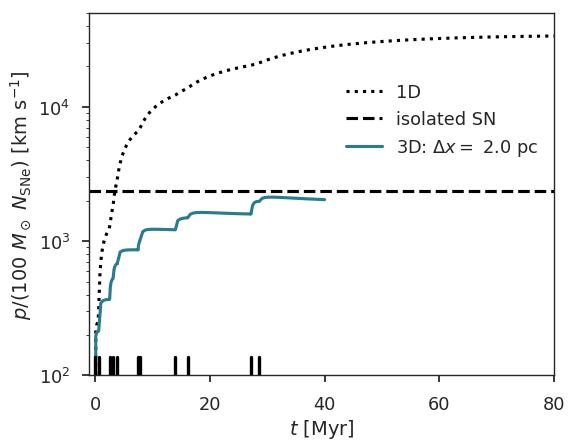

In [21]:
resolution_study_plotter([200], times_snapshots, radial_momenta,
                         N_particles_per_side_mhd, times_snapshots_mhd, radial_momenta_mhd,
                         with_MHD=False,
                         with_legend=False,
                        )

plt.axhline(isolated_SN_momentum, linestyle="dashed", color="black", label="isolated SN")

handles, labels = plt.gca().get_legend_handles_labels()
new_legend_order = [0,2,1]
plt.legend([handles[i] for i in new_legend_order], 
           [labels[i] for i in new_legend_order],
           loc="upper right", bbox_to_anchor=(1, 0.85))

plt.xlim(xmax=80)
plt.ylim(100,50000)

In [22]:
[labels[i] for i in new_legend_order]

['1D', 'isolated SN', '3D: $\\Delta x = $ 2.0 pc']

(100, 50000)

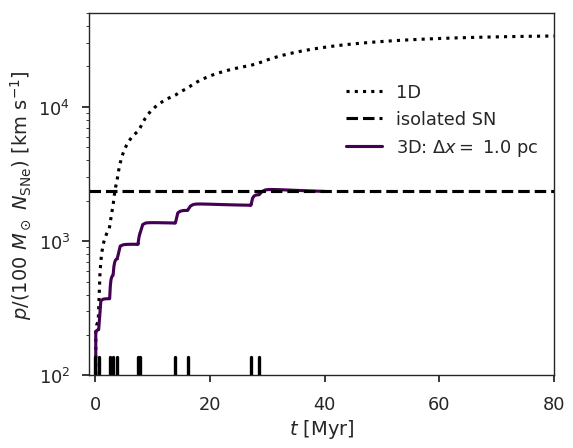

In [23]:
resolution_study_plotter([400], times_snapshots, radial_momenta,
                         N_particles_per_side_mhd, times_snapshots_mhd, radial_momenta_mhd,
                         with_MHD=False)

plt.axhline(isolated_SN_momentum, linestyle="dashed", color="black", label="isolated SN")

handles, labels = plt.gca().get_legend_handles_labels()
new_legend_order = [0,2,1]
plt.legend([handles[i] for i in new_legend_order], 
           [labels[i] for i in new_legend_order],
           loc="upper right", bbox_to_anchor=(1, 0.85))

plt.xlim(xmax=80)
plt.ylim(100,50000)

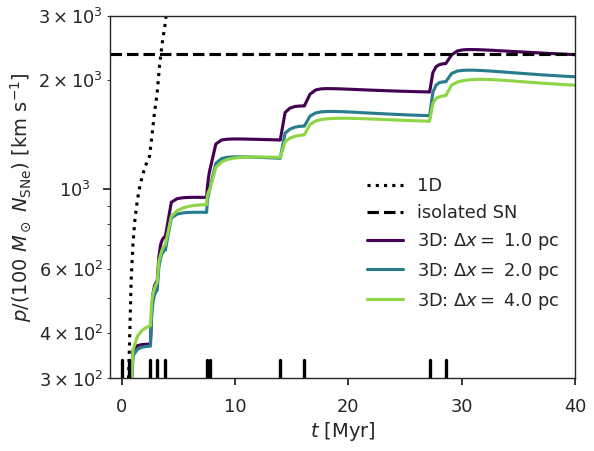

In [24]:
resolution_study_plotter(N_particles_tmp, times_snapshots, radial_momenta,
                         N_particles_per_side_mhd, times_snapshots_mhd, radial_momenta_mhd,
                         with_MHD=False)

plt.axhline(isolated_SN_momentum, linestyle="dashed", color="black", label="isolated SN")

handles, labels = plt.gca().get_legend_handles_labels()
new_legend_order = [0, -1, 1, 2, 3]
plt.legend([handles[i] for i in new_legend_order], 
           [labels[i] for i in new_legend_order],
           loc="upper right", bbox_to_anchor=(1, 0.6))


# plt.legend(loc="upper right", bbox_to_anchor=(1,.6))

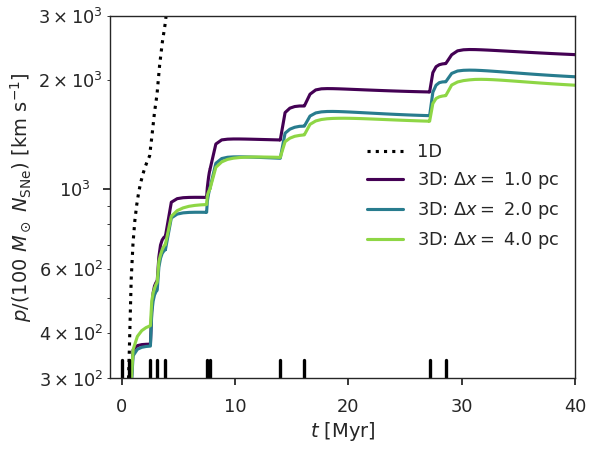

In [25]:
resolution_study_plotter(N_particles_tmp, times_snapshots, radial_momenta,
                         N_particles_per_side_mhd, times_snapshots_mhd, radial_momenta_mhd,
                         with_MHD=False)

### With MHD

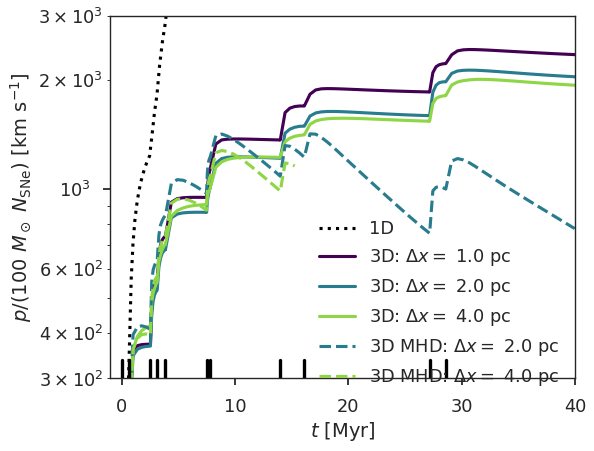

In [26]:
resolution_study_plotter(N_particles_tmp, times_snapshots, radial_momenta,
                         N_particles_per_side_mhd, times_snapshots_mhd, radial_momenta_mhd,
                         with_MHD=True)

plt.legend(loc="upper right", bbox_to_anchor=(1,.48))

In [27]:
df = pd.read_csv("../runs/cluster_cooling_mhd_large_200/outputs/MHD.csv")
# df

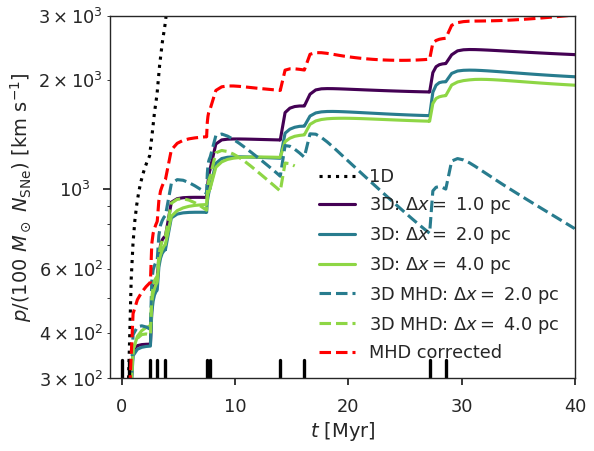

In [28]:
resolution_study_plotter(N_particles_tmp, times_snapshots, radial_momenta,
                         N_particles_per_side_mhd, times_snapshots_mhd, radial_momenta_mhd,
                         with_MHD=True)

mhd_csv_filename = "../runs/cluster_cooling_mhd_large_200/outputs/MHD.csv"
if os.path.exists(mhd_csv_filename):
    df = pd.read_csv(mhd_csv_filename)
    plt.plot(df.time, df.corrected, 
             color="r", linestyle="dashed", label="MHD corrected",
            )
    
plt.legend(loc="best")

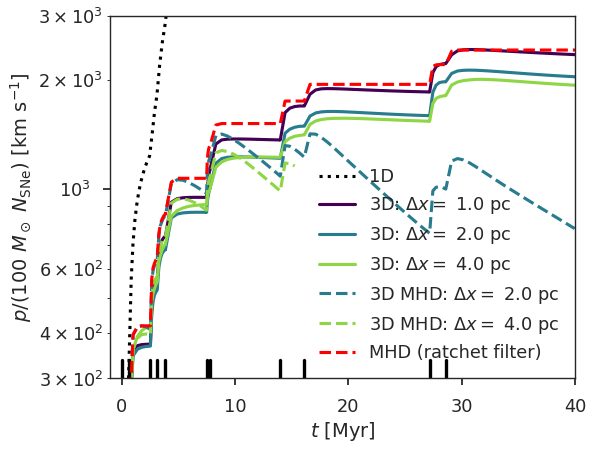

In [29]:
resolution_study_plotter(N_particles_tmp, times_snapshots, radial_momenta,
                         N_particles_per_side_mhd, times_snapshots_mhd, radial_momenta_mhd,
                         with_MHD=True)

mhd_csv_filename = "../runs/cluster_cooling_mhd_large_200/outputs/MHD.csv"
if os.path.exists(mhd_csv_filename):
    df = pd.read_csv(mhd_csv_filename)
    plt.plot(df.time, df.ratcheted, 
             color="r", linestyle="dashed", label="MHD (ratchet filter)",
            )
    
plt.legend(loc="best")

# For my qual

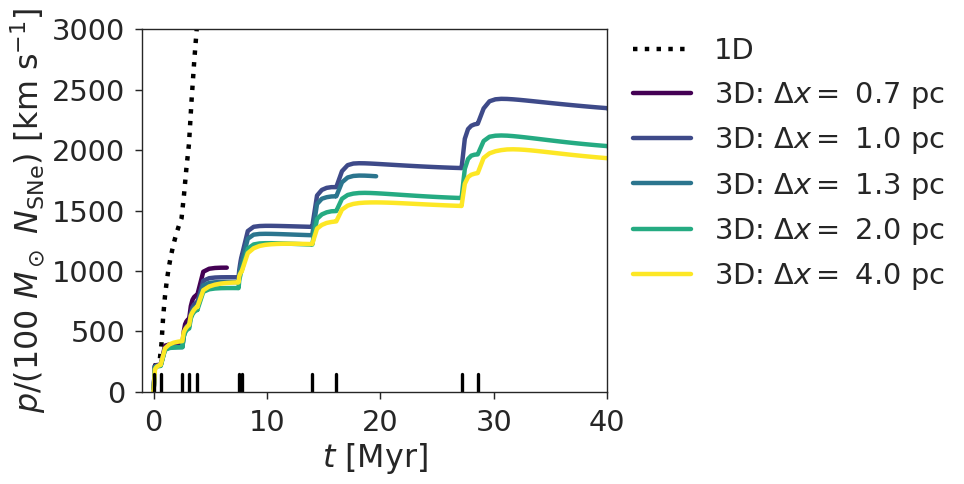

In [36]:
with sns.plotting_context(context="talk", font_scale=2):
    plt.plot((run_summary.times - run_summary.overview.SNe_times[0]) / (Myr),
             run_summary.momentum / (100 * M_solar * 11 * km / s),
             label="1D",
             linestyle="dotted", color="k",
             linewidth=4
             )


    for N_particles_per_side_i in N_particles_per_side[::-1]:

        plt.plot(times_snapshots[N_particles_per_side_i],
                 radial_momenta[N_particles_per_side_i] / (100 * M_solar * 11 * km / s),
                 label="3D: $\Delta x = $ {:.1f} pc".format(400 / N_particles_per_side_i),
                 color=N_particles_to_color(N_particles_per_side_i),
                 linewidth=4,
                 )

#     for N_particles_per_side_i in N_particles_per_side_mhd[::-1]:

#         plt.plot(times_snapshots_mhd[N_particles_per_side_i],
#                  radial_momenta_mhd[N_particles_per_side_i] / (100 * M_solar * 11 * km / s),
#                  label="3D MHD: $\Delta x = $ {:.1f} pc".format(400 / N_particles_per_side_i),
#                  linestyle="dashed", 
#                  color=N_particles_to_color(N_particles_per_side_i),
#                  linewidth=4,
#                 )


    sns.rugplot(SN_times_3D, color="k", linewidth=3)

    plt.xlabel(r"$t$ $[\mathrm{Myr}]$")
    plt.ylabel(r"$p / (100$ $M_\odot$ $N_\mathrm{SNe})$ $[\mathrm{km}$ $\mathrm{s}^{-1}]$")


    plt.xlim(xmin=-1,
             xmax=40)
    plt.ylim(
        ymin=0,
#         ymin=300,
             ymax=3000,
            )

#     plt.yscale("log")

    plt.legend(
#         loc="best",
              loc="upper left", bbox_to_anchor=(1, 1.05),
              )

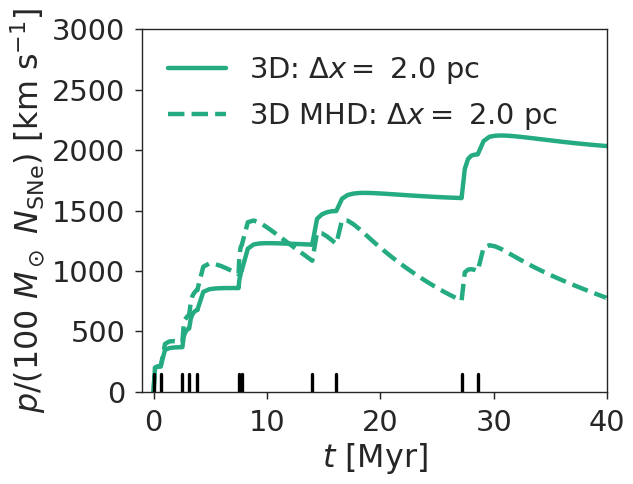

In [37]:
with sns.plotting_context(context="talk", font_scale=2):
#     plt.plot((run_summary.times - run_summary.overview.SNe_times[0]) / (Myr),
#              run_summary.momentum / (100 * M_solar * 11 * km / s),
#              label="1D",
#              linestyle="dotted", color="k",
#              linewidth=4
#              )


#     for N_particles_per_side_i in N_particles_per_side[::-1]:
    for N_particles_per_side_i in [200]:

        plt.plot(times_snapshots[N_particles_per_side_i],
                 radial_momenta[N_particles_per_side_i] / (100 * M_solar * 11 * km / s),
                 label="3D: $\Delta x = $ {:.1f} pc".format(400 / N_particles_per_side_i),
                 color=N_particles_to_color(N_particles_per_side_i),
                 linewidth=4,
                 )

    for N_particles_per_side_i in N_particles_per_side_mhd[::-1]:

        plt.plot(times_snapshots_mhd[N_particles_per_side_i],
                 radial_momenta_mhd[N_particles_per_side_i] / (100 * M_solar * 11 * km / s),
                 label="3D MHD: $\Delta x = $ {:.1f} pc".format(400 / N_particles_per_side_i),
                 linestyle="dashed", 
                 color=N_particles_to_color(N_particles_per_side_i),
                 linewidth=4,
                )


    sns.rugplot(SN_times_3D, color="k", linewidth=3)

    plt.xlabel(r"$t$ $[\mathrm{Myr}]$")
    plt.ylabel(r"$p / (100$ $M_\odot$ $N_\mathrm{SNe})$ $[\mathrm{km}$ $\mathrm{s}^{-1}]$")


    plt.xlim(xmin=-1,
             xmax=40)
    plt.ylim(
        ymin=0,
             ymax=3000,
            )

#     plt.yscale("log")

    plt.legend(
        loc="best",
#               loc="upper left", bbox_to_anchor=(1, 1.05),
              )